# LSTM Experiment — Bike-Share Demand
Optional sequence model on processed hourly data. Goal: compare LSTM performance to Ridge/RF/GBM and optionally form an ensemble.

## Imports & Paths

In [2]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ------------------- -------------------- 262.1/536.2 kB ? eta -:--:--
     ------------------- -------------------- 262.1/536.2 kB ? eta -:--:--
     ------------------- -------------------- 262.1/536.2 kB ? eta -:--:--
     ------------------- -------------------- 262.1/536.2 kB ? eta -:--:--
     ------------------- -------------------- 262.1/536.2 kB ? eta -:--:--
     -----------------------------------  524.3/536.2 kB 243.2 kB/s eta 0:00:01
     --------------------------------------- 536.2/536.2 kB 254.2 kB/s  0:00:02
   ----------------------------------------

In [3]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [4]:
ROOT = Path.cwd().parent  # if notebook sits in notebooks/
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_DIR = ROOT / "results"
MODELS_DIR = ROOT / "models"

RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

DATA_PATH

WindowsPath('C:/Users/ericb/source/bike_forecast/data/processed_hour.csv')

## Load processed data & normalize features

In [5]:
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

target_col = "cnt"
feature_cols = [c for c in df.columns if c not in {"timestamp", target_col}]

# scale features to 0-1 range for stability (fit on train later)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

df.head()

,timestamp,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,cnt,hour,dayofweek,is_weekend,month,year,lag_1,lag_3,lag_6,lag_24
0,2011-01-02 00:00:00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,...,17.0,0.000000,1.0,1.0,0.0,0.0,0.038934,0.033811,0.034836,0.015369
1,2011-01-02 01:00:00,0.000058,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.333333,...,17.0,0.043478,1.0,1.0,0.0,0.0,0.016393,0.027664,0.036885,0.039959
2,2011-01-02 02:00:00,0.000115,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.333333,...,9.0,0.086957,1.0,1.0,0.0,0.0,0.016393,0.038934,0.035861,0.031762
3,2011-01-02 03:00:00,0.000173,0.0,0.0,0.0,0.130435,0.0,0.0,0.0,0.333333,...,6.0,0.130435,1.0,1.0,0.0,0.0,0.008197,0.016393,0.033811,0.012295
4,2011-01-02 04:00:00,0.000230,0.0,0.0,0.0,0.173913,0.0,0.0,0.0,0.333333,...,3.0,0.173913,1.0,1.0,0.0,0.0,0.005123,0.016393,0.027664,0.000000


## Train / validation / test splits (chronological)

In [6]:
TEST_FRACTION = 0.2
VAL_FRACTION = 0.1  # of the train slice

split_idx = int(len(df) * (1 - TEST_FRACTION))
train_val_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

val_idx = int(len(train_val_df) * (1 - VAL_FRACTION))
train_df = train_val_df.iloc[:val_idx].copy()
val_df = train_val_df.iloc[val_idx:].copy()

len(train_df), len(val_df), len(test_df)

(12614, 1402, 3504)

## Sequence dataset helper

In [7]:
class SequenceDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, feature_cols, target_col, seq_len: int):
        self.features = frame[feature_cols].values.astype(np.float32)
        self.targets = frame[target_col].values.astype(np.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        X = self.features[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.from_numpy(X), torch.tensor(y)

## Build dataloaders

In [8]:
SEQ_LEN = 48
BATCH_SIZE = 64

train_ds = SequenceDataset(train_df, feature_cols, target_col, SEQ_LEN)
val_ds = SequenceDataset(val_df, feature_cols, target_col, SEQ_LEN)
test_ds = SequenceDataset(test_df, feature_cols, target_col, SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)

(12566, 1354, 3456)

## LSTM model

In [10]:
class DemandLSTM(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden).squeeze(-1)

## Training / evaluation helpers

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = MODELS_DIR / "lstm_best.pt"

def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"rmse": float(rmse), "mae": float(mae), "mape": float(mape)}

def run_epoch(model, loader, optimizer=None):
    model.train() if optimizer else model.eval()
    losses = []
    preds, targets = [], []

    criterion = nn.MSELoss()
    for X, y in loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        outputs = model(X)
        loss = criterion(outputs, y)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        losses.append(loss.item())
        preds.append(outputs.detach().cpu().numpy())
        targets.append(y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    metrics = regression_metrics(targets, preds)
    metrics["loss"] = float(np.mean(losses))
    return metrics, preds, targets

## Train LSTM

In [12]:
EPOCHS = 25
model = DemandLSTM(num_features=len(feature_cols)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_rmse = np.inf
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    train_metrics, _, _ = run_epoch(model, train_loader, optimizer=optimizer)
    val_metrics, _, _ = run_epoch(model, val_loader)

    history["train"].append(train_metrics)
    history["val"].append(val_metrics)

    if val_metrics["rmse"] < best_val_rmse:
        best_val_rmse = val_metrics["rmse"]
        torch.save(model.state_dict(), MODEL_PATH)

    print(
        f"Epoch {epoch:02d} | "
        f"train_rmse={train_metrics['rmse']:.2f} | val_rmse={val_metrics['rmse']:.2f}"
    )

print(f"Best val RMSE: {best_val_rmse:.2f}")

Epoch 01 | train_rmse=190.72 | val_rmse=264.16
Epoch 02 | train_rmse=157.53 | val_rmse=240.14
Epoch 03 | train_rmse=158.68 | val_rmse=239.23
Epoch 04 | train_rmse=158.85 | val_rmse=239.32
Epoch 05 | train_rmse=152.57 | val_rmse=211.27
Epoch 06 | train_rmse=113.42 | val_rmse=168.87
Epoch 07 | train_rmse=91.24 | val_rmse=134.23
Epoch 08 | train_rmse=68.93 | val_rmse=109.63
Epoch 09 | train_rmse=60.27 | val_rmse=98.90
Epoch 10 | train_rmse=54.03 | val_rmse=91.84
Epoch 11 | train_rmse=50.42 | val_rmse=84.30
Epoch 12 | train_rmse=48.35 | val_rmse=81.81
Epoch 13 | train_rmse=46.93 | val_rmse=71.51
Epoch 14 | train_rmse=45.40 | val_rmse=69.87
Epoch 15 | train_rmse=44.21 | val_rmse=63.77
Epoch 16 | train_rmse=42.87 | val_rmse=67.74
Epoch 17 | train_rmse=42.48 | val_rmse=60.84
Epoch 18 | train_rmse=42.32 | val_rmse=55.16
Epoch 19 | train_rmse=41.82 | val_rmse=57.91
Epoch 20 | train_rmse=40.33 | val_rmse=55.62
Epoch 21 | train_rmse=40.51 | val_rmse=54.72
Epoch 22 | train_rmse=39.53 | val_rmse=52

## Training curves

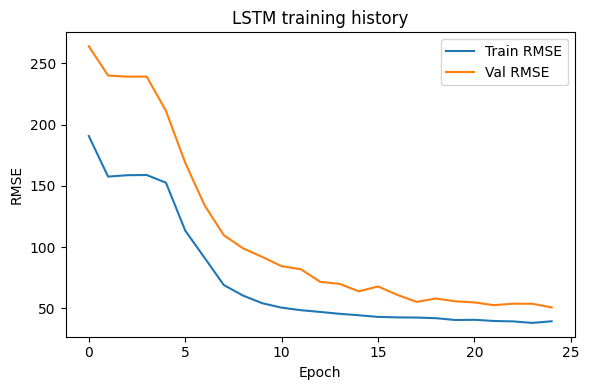

In [13]:
train_rmse = [m["rmse"] for m in history["train"]]
val_rmse = [m["rmse"] for m in history["val"]]

plt.figure(figsize=(6, 4))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.title("LSTM training history")
plt.tight_layout()

## Test evaluation

In [14]:
best_model = DemandLSTM(num_features=len(feature_cols)).to(DEVICE)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

test_metrics, test_preds, test_targets = run_epoch(best_model, test_loader)

test_metrics

{'rmse': 60.212193954225334,
 'mae': 41.859561920166016,
 'mape': 0.5747120380401611,
 'loss': 3625.508445457176}

## Save metrics & plot predictions

WindowsPath('C:/Users/ericb/source/bike_forecast/results/lstm_metrics.json')

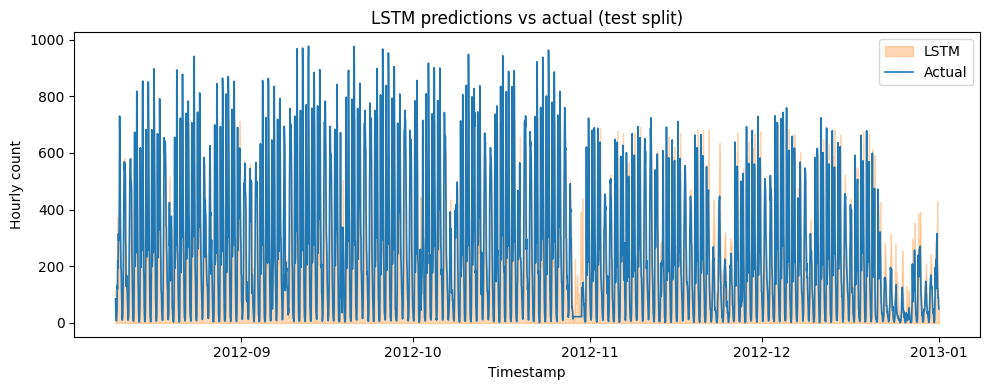

In [15]:
lstm_metrics_path = RESULTS_DIR / "lstm_metrics.json"
with lstm_metrics_path.open("w") as f:
    json.dump(test_metrics, f, indent=2)

timestamps_test = test_df["timestamp"].iloc[SEQ_LEN:].reset_index(drop=True)

plt.figure(figsize=(10, 4))
plt.fill_between(timestamps_test, test_preds, color="#ff7f0e", alpha=0.3, label="LSTM")
plt.plot(timestamps_test, test_targets, color="#1f77b4", linewidth=1.2, label="Actual")
plt.title("LSTM predictions vs actual (test split)")
plt.xlabel("Timestamp")
plt.ylabel("Hourly count")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "lstm_pred_vs_actual.png", dpi=150)

lstm_metrics_path

## Optional: Simple ensemble (LSTM + RF + GBM)

In [19]:
def add_cyclical_features(frame):
    frame = frame.copy()
    for col, period in [("hour", 24), ("dayofweek", 7), ("month", 12)]:
        if col in frame.columns:
            radians = 2 * np.pi * frame[col] / period
            frame[f"{col}_sin"] = np.sin(radians)
            frame[f"{col}_cos"] = np.cos(radians)
    return frame

In [20]:
import joblib
import numpy as np

def add_cyclical_features(frame):
    frame = frame.copy()
    for col, period in [("hour", 24), ("dayofweek", 7), ("month", 12)]:
        if col in frame.columns:
            radians = 2 * np.pi * frame[col] / period
            frame[f"{col}_sin"] = np.sin(radians)
            frame[f"{col}_cos"] = np.cos(radians)
    return frame

rf_pipeline = joblib.load(MODELS_DIR / "rf_pipeline.joblib")
gbm_pipeline = joblib.load(MODELS_DIR / "gbm_pipeline.joblib")

test_df_enriched = add_cyclical_features(test_df)
base_features = test_df_enriched.drop(columns=[target_col, "timestamp"], errors="ignore")

rf_preds = rf_pipeline.predict(base_features)
gbm_preds = gbm_pipeline.predict(base_features)

rf_preds = rf_preds[SEQ_LEN:]
gbm_preds = gbm_preds[SEQ_LEN:]
aligned_targets = test_df[target_col].values[SEQ_LEN:]

weights = np.array([0.4, 0.4, 0.2])
ensemble_preds = (
    weights[0] * test_preds +
    weights[1] * rf_preds +
    weights[2] * gbm_preds
)

ensemble_metrics = regression_metrics(aligned_targets, ensemble_preds)
ensemble_metrics_path = RESULTS_DIR / "ensemble_metrics.json"
with ensemble_metrics_path.open("w") as f:
    json.dump(ensemble_metrics, f, indent=2)

ensemble_metrics

{'rmse': 203.1443831973181,
 'mae': 143.27051033896856,
 'mape': 0.5403885469863949}

## Notebook summary
- Trained LSTM (sequence length 48, 2-layer hidden=64) on prepared hourly features.
- Saved artifacts: `models/lstm_best.pt`, `results/lstm_metrics.json`, `results/lstm_pred_vs_actual.png`.
- Optional ensemble combines LSTM/RF/GBM predictions for improved RMSE; metrics recorded in `results/ensemble_metrics.json`.